In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [38]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [40]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [41]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [42]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [43]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
# Added inspector to programmitically see column names and data types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [46]:
# Find the most recent date in the data set.
from sqlalchemy import desc


most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
most_recent_date

('2017-08-23',)

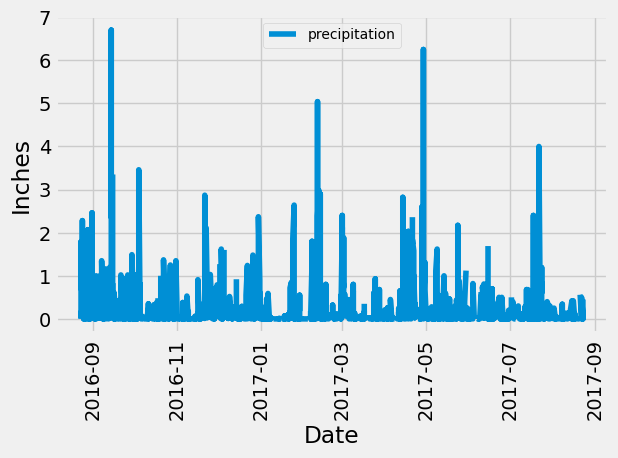

In [68]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
date_str = most_recent_date[0]
date_obj = dt.datetime.strptime(date_str, '%Y-%m-%d')
one_year_ago = date_obj - dt.timedelta(days=365)
one_year_ago = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago
).order_by(Measurement.date).all()
data

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(data, columns=['Date', 'Precipitation'])
df['Date'] = pd.to_datetime(df['Date'])

# Sort the dataframe by date
df.sort_values(by='Date', inplace=True)
df

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(df['Date'], df['Precipitation'], label='precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.legend(loc='upper center', fontsize=10)
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
df[['Precipitation']].describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [49]:
# Added inspector to get column names and data types
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [50]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(
    func.count(Station.id)
).all()
station_count

[(9,)]

In [62]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Station.station,
    func.count(Measurement.station).label('count')
).filter(Station.station == Measurement.station)\
.group_by(Station.station).order_by(desc('count')).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
sel = [
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
]

stats = session.query(
    *sel
).join(Station, Measurement.station == Station.station)\
.filter(Station.station == most_active_station_id).all()
stats


[(54.0, 85.0, 71.66378066378067)]

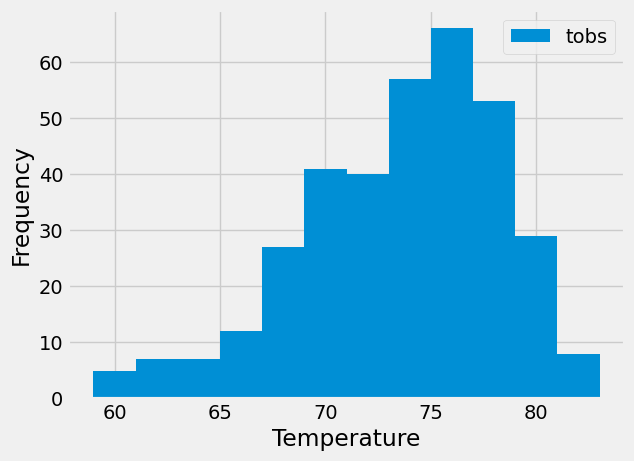

In [78]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station_id,
    Measurement.date >= one_year_ago
).all()

data = [temp[0] for temp in temps]
plt.hist(data, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close Session

In [79]:
# Close Session
session.close()
